In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from tqdm import tqdm
from matplotlib.colors import LogNorm
# from censai.data.lenses_tng import decode_all, decode_train, decode_physical_model_info
# from censai.data.lenses_tng_v2 import decode_all, decode_train, decode_physical_model_info
from censai.data.lenses_tng_v3 import decode_all, decode_train, decode_physical_model_info

from astropy.visualization import ImageNormalize, LogStretch
from matplotlib.colors import LogNorm, SymLogNorm, CenteredNorm
from censai.definitions import log_10
import h5py

2021-11-16 10:00:31.168628: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-11-16 10:00:34.441308: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-16 10:00:34.442424: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-16 10:00:34.499857: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2021-11-16 10:00:34.499878: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-11-16 10:00:34.504167: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2

In [3]:
# datapath = "/home/aadam/scratch/Censai/data/lenses512_k128_TNG100/"
# datapath = "/home/aadam/scratch/Censai/data/lenses512_hk128_TNG100/"
# datapath = "/home/aadam/scratch/Censai/data/lenses512_hk128_TNG100_noshift40k/"
# datapath = "/home/aadam/scratch/Censai/data/lenses512_k128_NIE_10k/"
# datapath = "/home/aadam/scratch/Censai/data/lenses512_k128_NIE_10k_verydiffuse"
# datapath = "/home/aadam/scratch/Censai/data/lenses512_hk128_TNG100_10k_verydiffuse"
# datapath = "/home/aadam/scratch/Censai/data/lenses128_hTNG100_10k_verydiffuse"
# datapath = "/home/aadam/scratch/Censai/data/lenses128hst_TNG_VAE_200k_control_validated_train/"
# datapath = "/home/aadam/scratch/Censai/data/lenses128hst_TNG_VAE_2M/"
datapath = "/home/aadam/scratch/Censai/data/lenses128hst_TNG_rau_200k_control_denoised_validated_train"


files = glob.glob(os.path.join(datapath, "*.tfrecords"))
files = tf.data.Dataset.from_tensor_slices(files)
dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type="GZIP"), block_length=1, num_parallel_calls=tf.data.AUTOTUNE)
for physical_params in dataset.map(decode_physical_model_info):
    break
print(physical_params)
dataset = dataset.map(decode_all)
kappas = []
galaxies = []
lenses = []
noise_rms = []
psf_fwhm = []
i = 0
for example in tqdm(dataset):
    kappas.append(example['kappa'])
    galaxies.append(example['source'])
    lenses.append(example['lens'])
    noise_rms.append(example['noise rms'].numpy())
    psf_fwhm.append(example['fwhm'].numpy())
    i += 1
    if i == 1000:
        break
# dataset = dataset.map(decode_train).map(preprocess)
# kappas = []
# galaxies = []
# lenses = []
# noise = []
# psfs = []
# i = 0
# for lens, source, kappa, noise_rms, psf in tqdm(dataset):
#     kappas.append(kappa)
#     galaxies.append(source)
#     lenses.append(lens)
#     noise.append(noise_rms.numpy())
#     psfs.append(psf)
#     i += 1
#     if i == 1000:
#         break

2021-11-16 10:01:02.591607: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-16 10:01:02.603568: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2645205000 Hz


{'image fov': <tf.Tensor: shape=(), dtype=float32, numpy=7.6887193>, 'kappa fov': <tf.Tensor: shape=(), dtype=float32, numpy=7.6887193>, 'source fov': <tf.Tensor: shape=(), dtype=float32, numpy=3.0>, 'src pixels': <tf.Tensor: shape=(), dtype=int64, numpy=128>, 'kappa pixels': <tf.Tensor: shape=(), dtype=int64, numpy=128>, 'pixels': <tf.Tensor: shape=(), dtype=int64, numpy=128>}


999it [00:01, 897.05it/s]


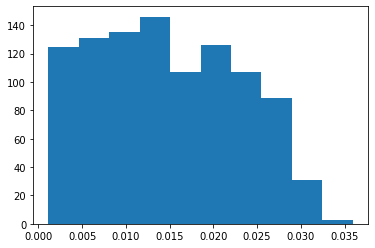

In [4]:
plt.hist(noise_rms, bins=10);

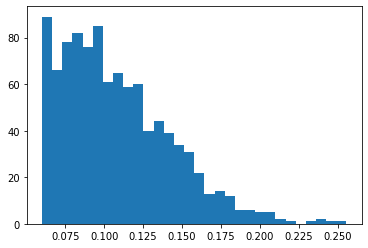

In [5]:
plt.hist(psf_fwhm, bins=30);

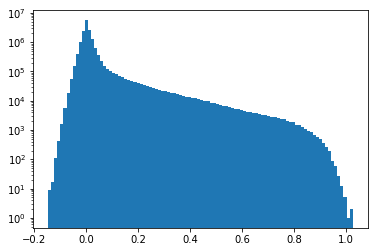

In [6]:
_lenses = tf.concat(lenses, axis=0)
plt.hist(_lenses.numpy().ravel(), bins=100);
plt.yscale("log")

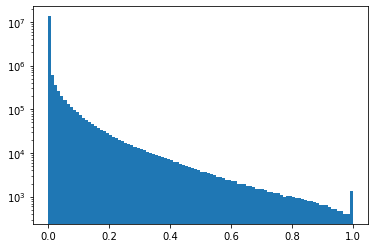

In [7]:
galaxy = tf.concat(galaxies, axis=0)
plt.hist(galaxy.numpy().ravel(), bins=100);
plt.yscale("log")

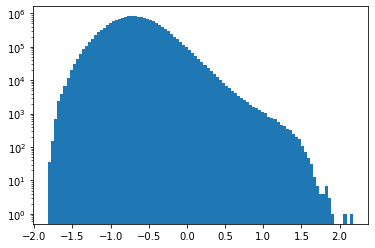

In [8]:
kappa = tf.concat(kappas, axis=0)
plt.hist(np.log10(np.maximum(kappa.numpy().ravel(), 1e-8)), bins=100);
plt.yscale("log")

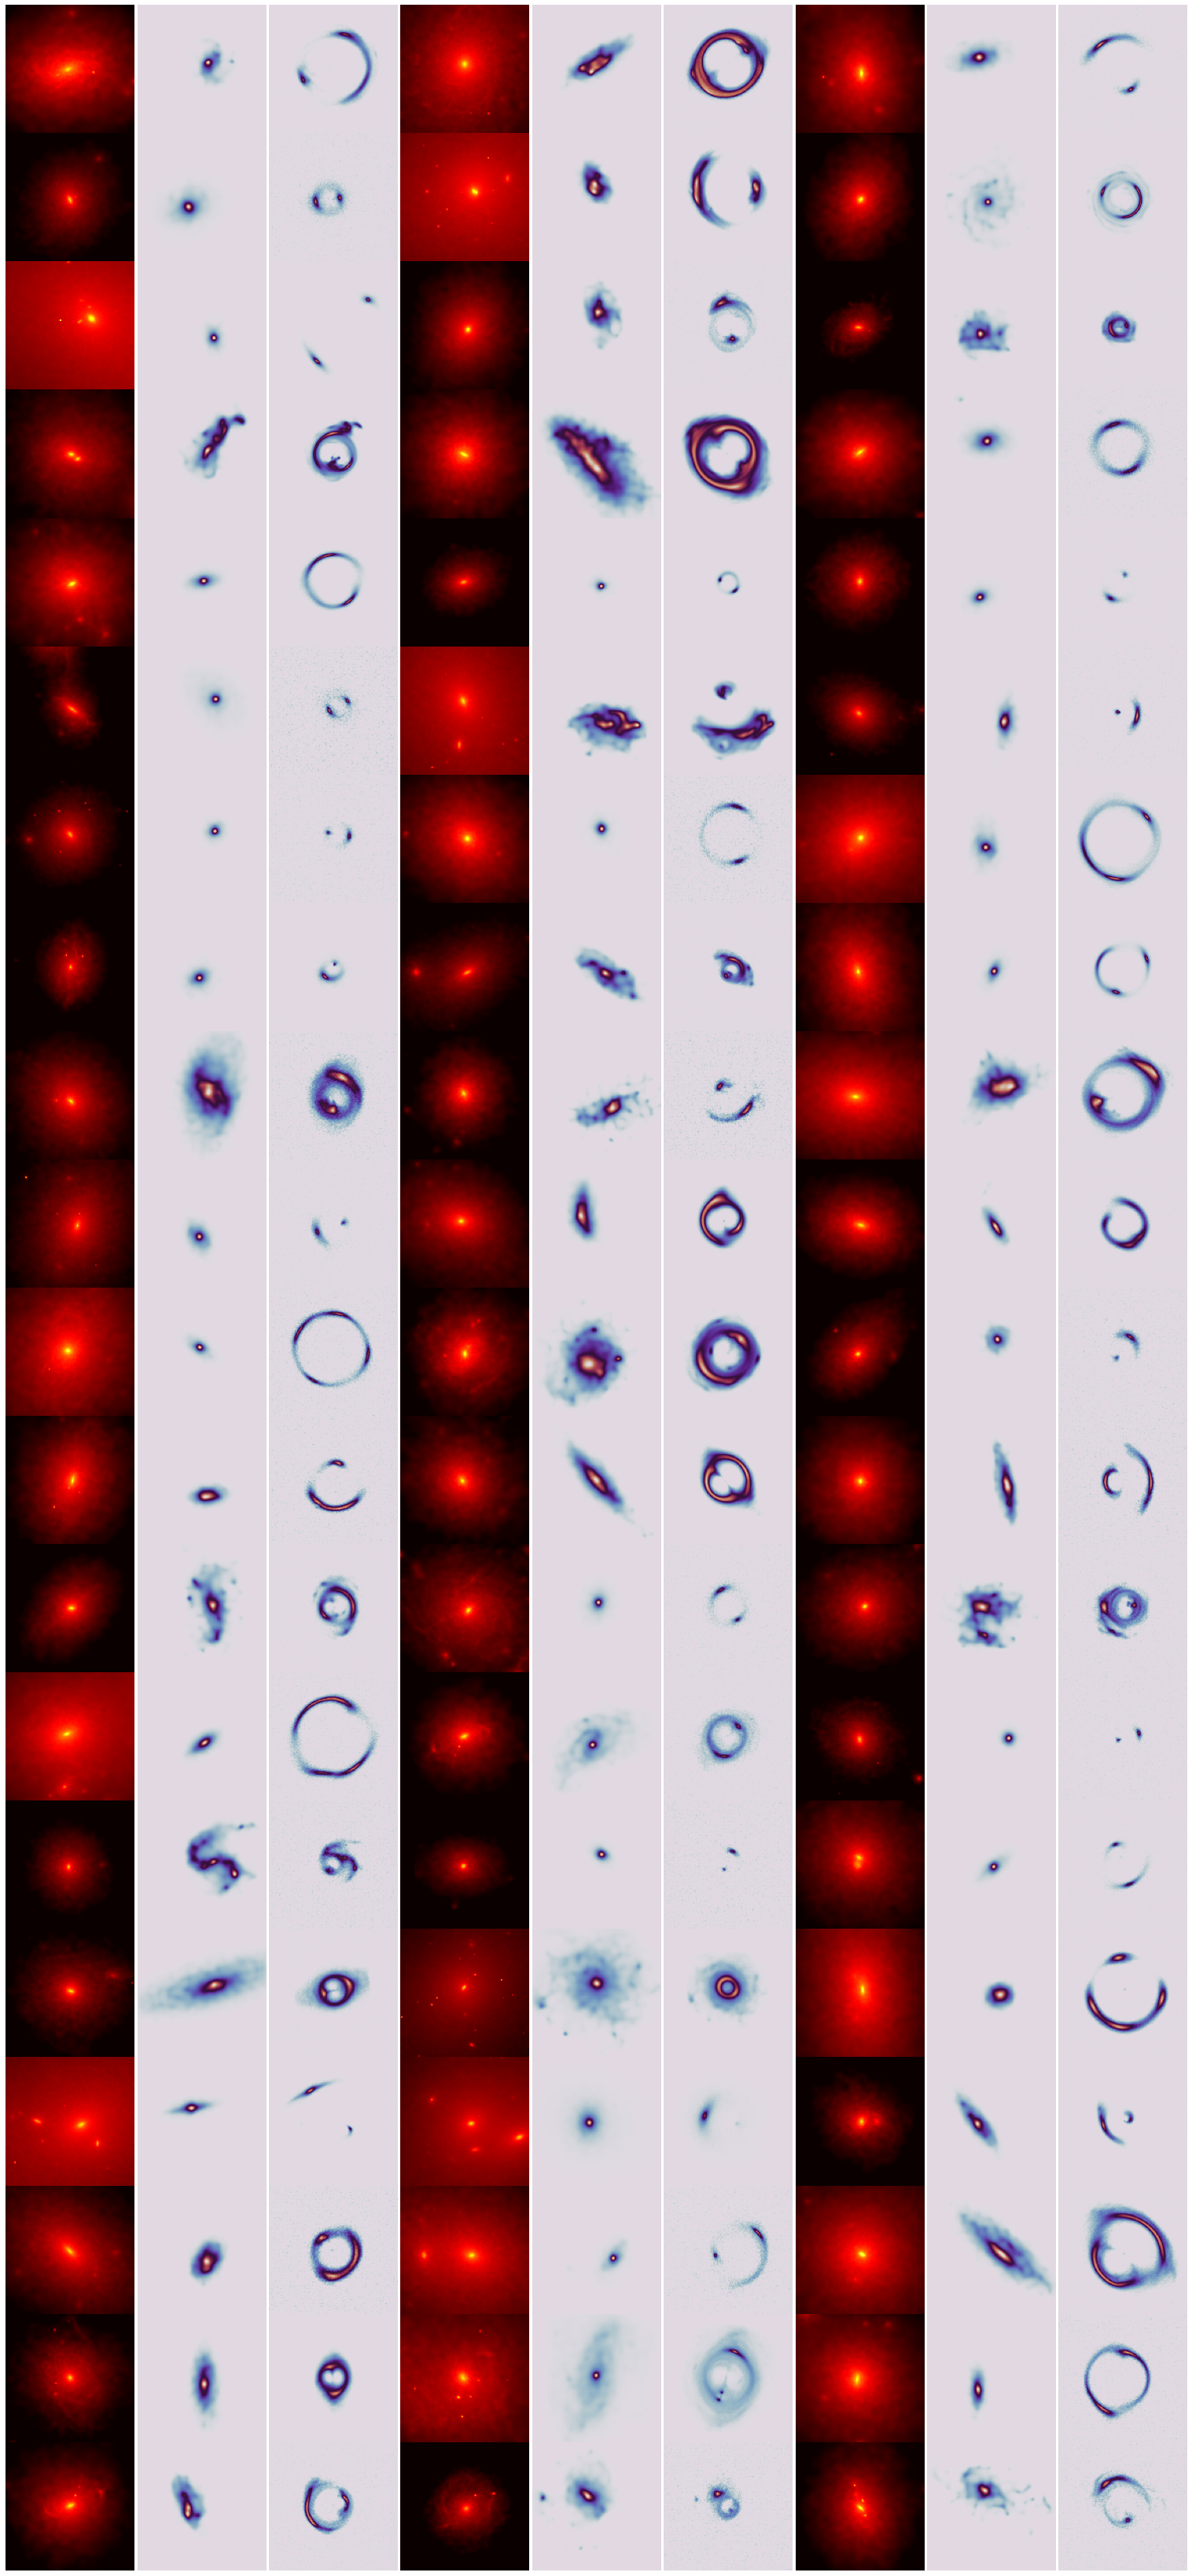

In [9]:
fig, axs = plt.subplots(20, 9, figsize=(27, 60))
start = 50
for i in range(0, 20):
#     cond = tf.reduce_max(lenses[i+start+40]* mask) > 0.4
#     im_area = tf.reduce_sum(tf.cast(lenses[i+start+40]> 0.2, tf.float32)) * (7.68 / 128) ** 2
#     src_area = tf.reduce_sum(tf.cast(galaxies[i+start+40] > 0.2, tf.float32)) * (3 / 128) ** 2
#     magnification = im_area/src_area
#     cond = magnification < 3
#     if cond:
#         cmap = "Blues"
#     else:
#         cmap = "bone"
    cmap = "twilight"
    axs[i, 0].imshow(kappas[i+start][..., 0], cmap="hot", norm=LogNorm(vmin=0.1, vmax=100))
    axs[i, 1].imshow(galaxies[i+start][..., 0], cmap="twilight", vmin=0, vmax=1)
    axs[i, 2].imshow(lenses[i+start][..., 0], cmap=cmap, vmin=0., vmax=1)
    for j in range(3):
        axs[i, j].axis("off")
        
for i in range(0, 20):
#     cond = tf.reduce_max(lenses[i+start+40]* mask) > 0.4
#     im_area = tf.reduce_sum(tf.cast(lenses[i+start+40]> 0.2, tf.float32)) * (7.68 / 128) ** 2
#     src_area = tf.reduce_sum(tf.cast(galaxies[i+start+40] > 0.2, tf.float32)) * (3 / 128) ** 2
#     magnification = im_area/src_area
#     cond = magnification < 3
#     if cond:
#         cmap = "Blues"
#     else:
#         cmap = "bone"
    cmap = "twilight"
    axs[i, 3].imshow(kappas[i+start+20][..., 0], cmap="hot", norm=LogNorm(vmin=0.1, vmax=100))
    axs[i, 4].imshow(galaxies[i+start+20][..., 0], cmap="twilight", vmin=0, vmax=1)
    axs[i, 5].imshow(lenses[i+start+20][..., 0], cmap=cmap, vmin=0., vmax=1)
    for j in range(3, 6):
        axs[i, j].axis("off")

for i in range(0, 20):
#     cond = tf.reduce_max(lenses[i+start+40]* mask) > 0.4
#     im_area = tf.reduce_sum(tf.cast(lenses[i+start+40]> 0.2, tf.float32)) * (7.68 / 128) ** 2
#     src_area = tf.reduce_sum(tf.cast(galaxies[i+start+40] > 0.2, tf.float32)) * (3 / 128) ** 2
#     magnification = im_area/src_area
#     cond = magnification < 3
#     if cond:
#         cmap = "Blues"
#     else:
#         cmap = "bone"
    cmap = "twilight"
    axs[i, 6].imshow(kappas[i+start+40][..., 0], cmap="hot", norm=LogNorm(vmin=0.1, vmax=100))
    axs[i, 7].imshow(galaxies[i+start+40][..., 0], cmap="twilight", vmin=0, vmax=1)
    axs[i, 8].imshow(lenses[i+start+40][..., 0], cmap=cmap, vmin=0., vmax=1)
    for j in range(6, 9):
        axs[i, j].axis("off")

plt.subplots_adjust(wspace=0, hspace=0)

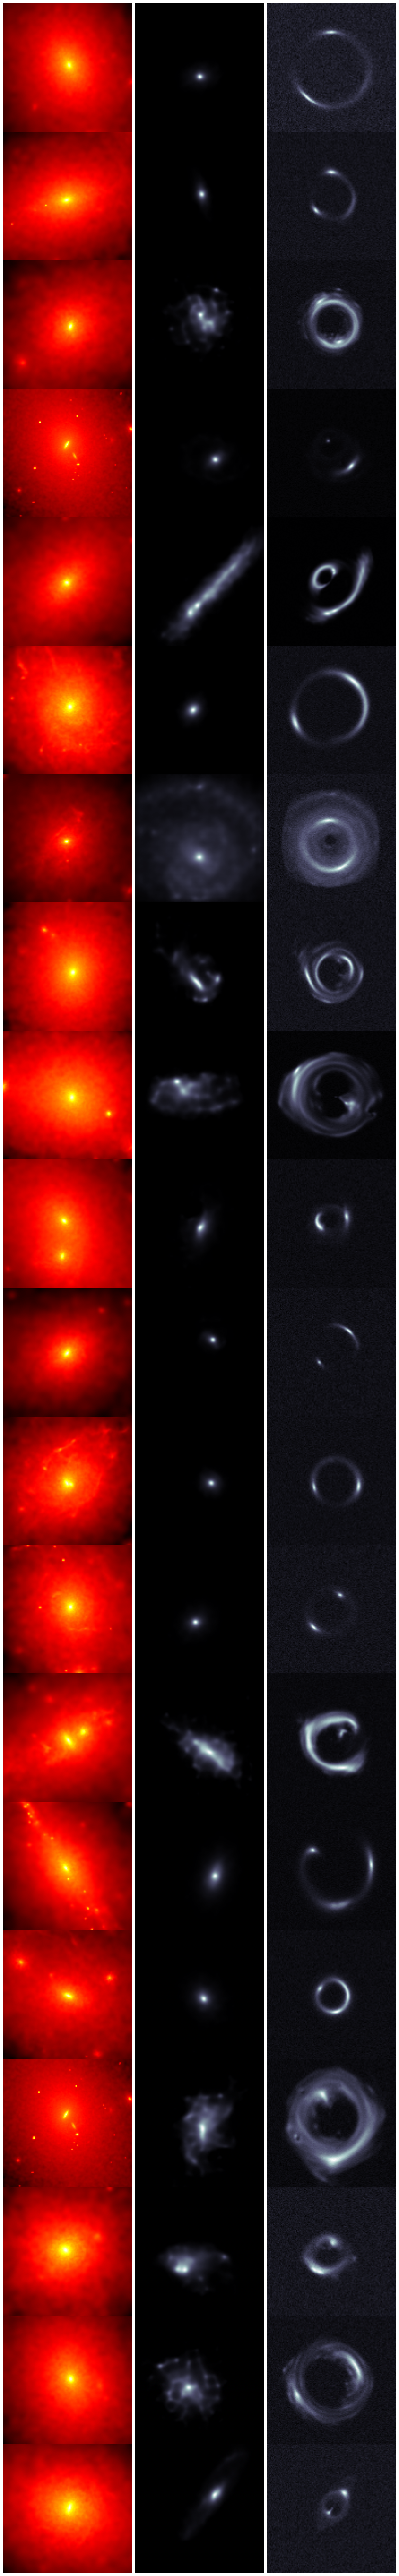

In [10]:
fig, axs = plt.subplots(20, 3, figsize=(15, 100))
start = 200
for i in range(0, 20):
    axs[i, 0].imshow(kappas[i+start][..., 0], cmap="hot", norm=ImageNormalize(stretch=LogStretch()))
    axs[i, 1].imshow(galaxies[i+start][..., 0], cmap="bone")
    axs[i, 2].imshow(lenses[i+start][..., 0], cmap="bone")
    for j in range(3):
        axs[i, j].axis("off")
plt.subplots_adjust(wspace=0, hspace=0)

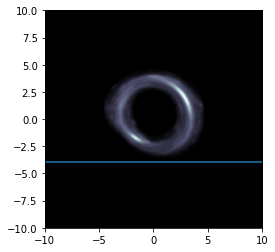

In [7]:
plt.imshow(lenses[208][..., 0], cmap="bone", extent=[-10, 10, -10, 10])
plt.axhline(-einstein_radius[208])

In [50]:
# fig, axs = plt.subplots(6, 12, figsize=(54, 27))
# start = 190
# ell = 0
# for i in range(6):
#     for j in range(12):
#         axs[i, j].imshow(transform(preprocess(kappas[ell+start][..., 0])), cmap="hot")
#         axs[i, j].axis("off")
#         ell += 1
# plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig("KappaTNG100.png")

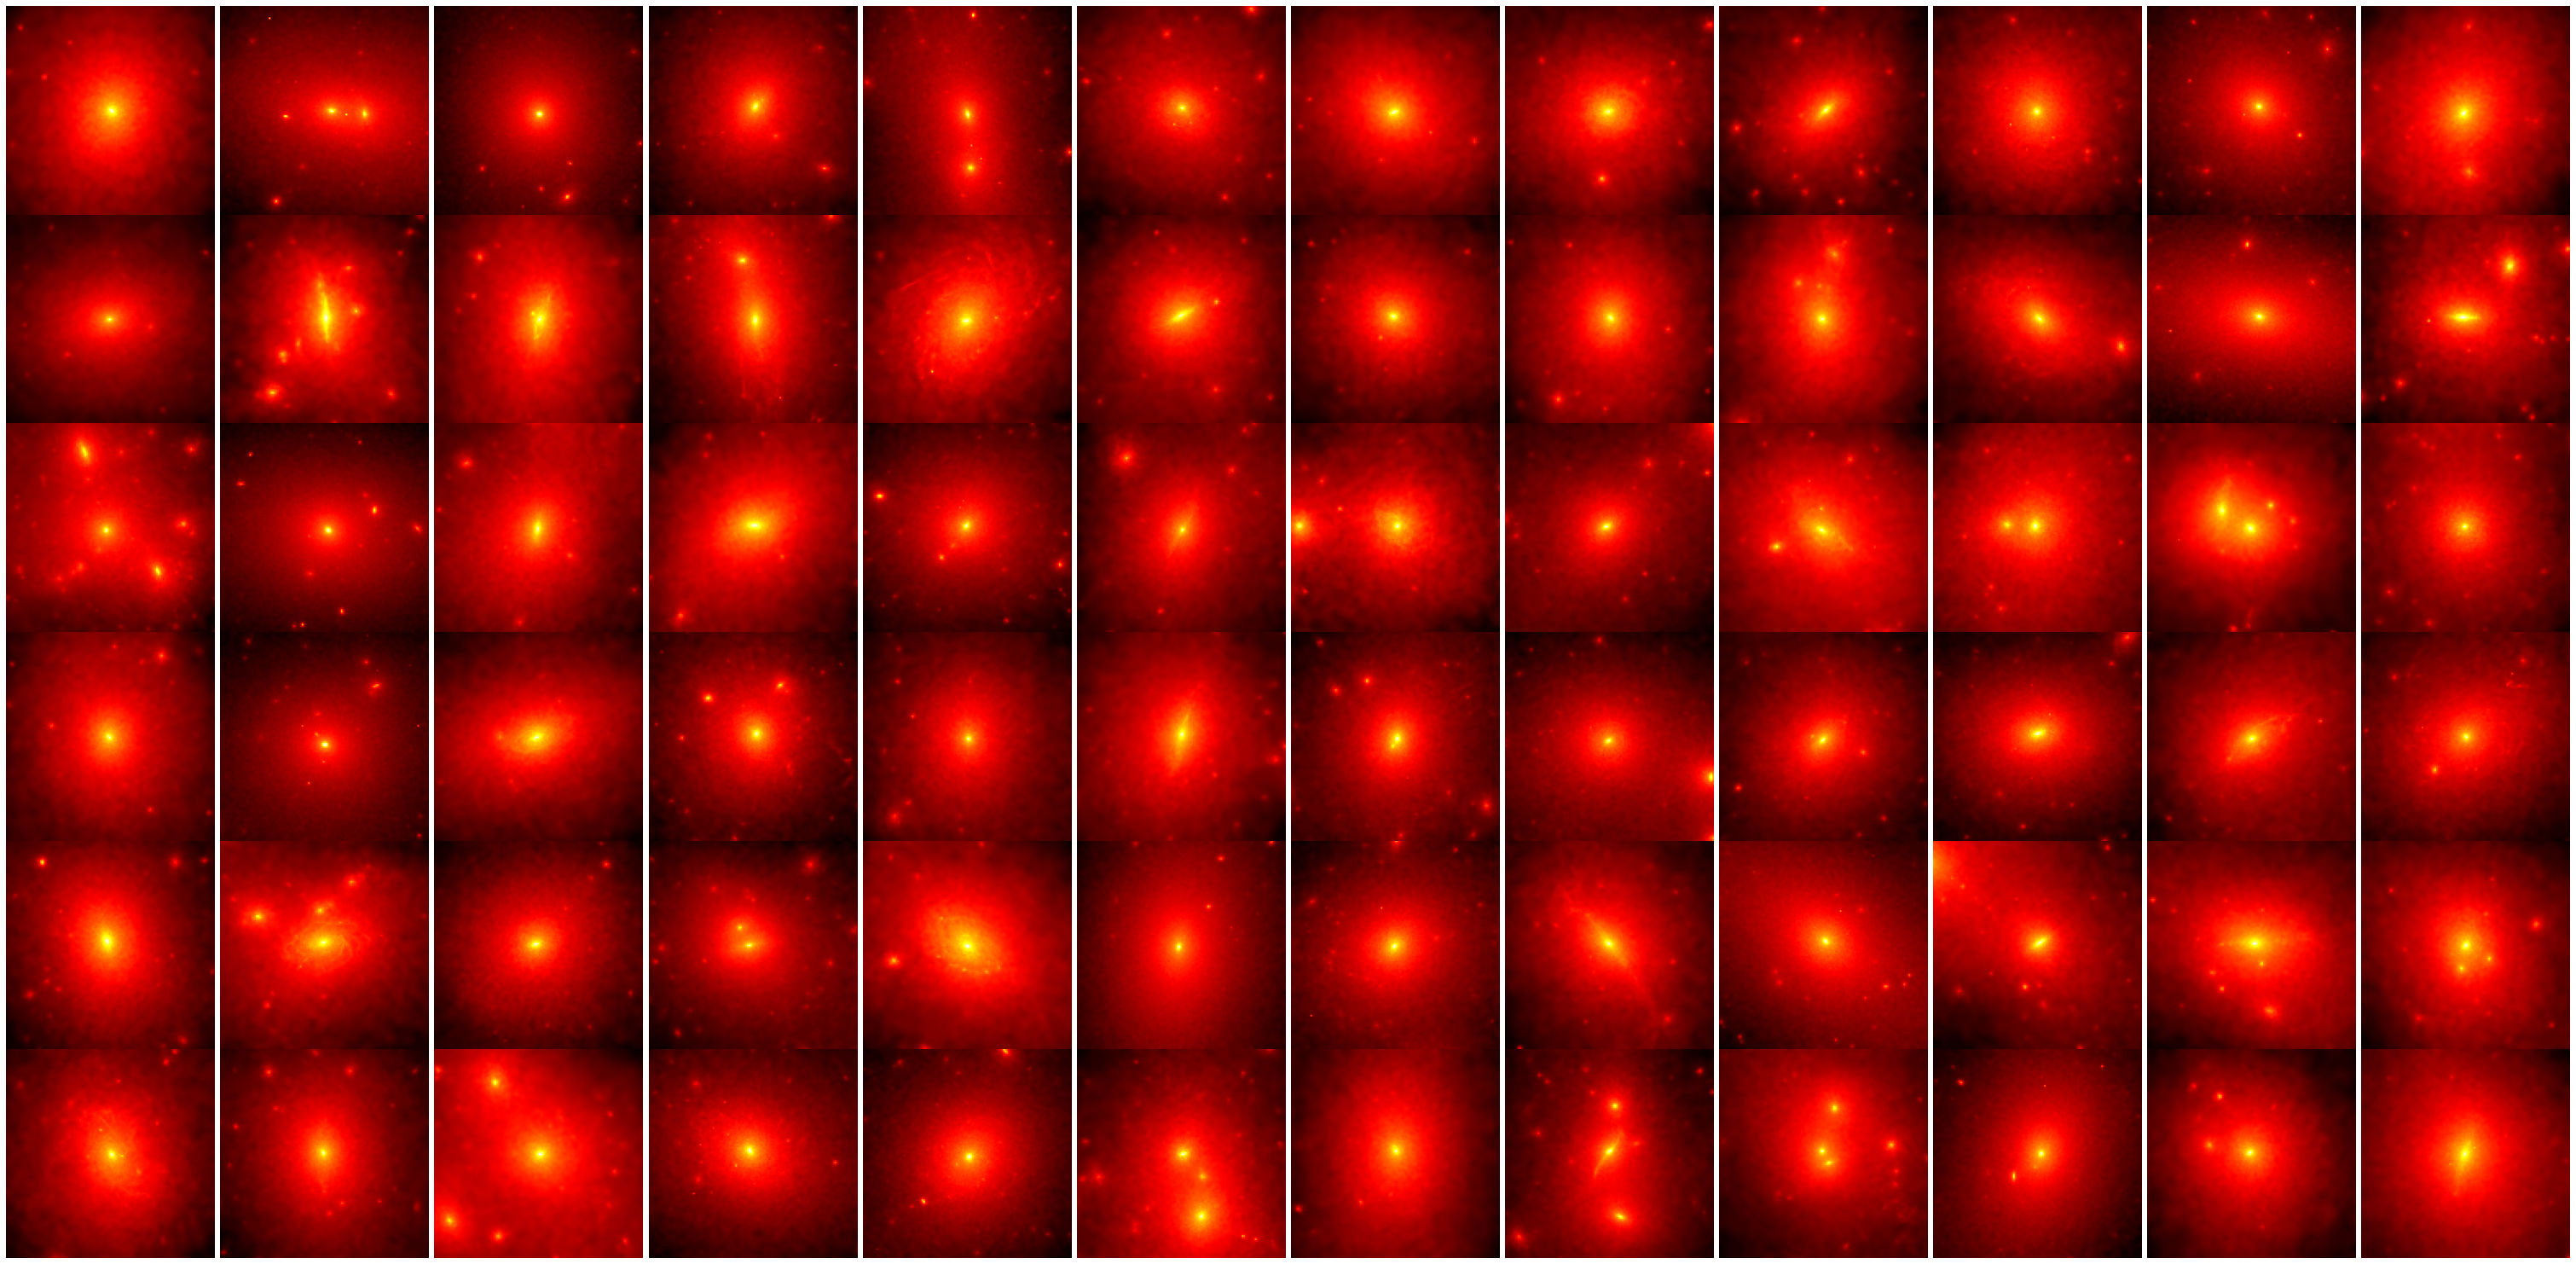

In [24]:
fig, axs = plt.subplots(6, 12, figsize=(54, 27))
start = 190
ell = 0
for i in range(6):
    for j in range(12):
        axs[i, j].imshow(preprocess(kappas[ell+start][..., 0]), cmap="hot")
        axs[i, j].axis("off")
        ell += 1
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("KappaTNG100.png")